In [ ]:
# 測試僅輸入文字的回應 (省略錄音步驟)
import sys
from pathlib import Path

# 自動加專案根目錄到 sys.path
sys.path.insert(0, str(Path().resolve().parents[0]))  # parents[0] = project/ 根目錄

from dotenv import load_dotenv
import os
from src.utils.file_io import read_text, write_text_file
from src.utils.config import *
# ACTIONS_FILE, MEMORY_FILE, HISTORY_FILE, REPLY_FILE

# langggraph_split_files
from src.nodes.langgraph_split_files.actions_schema import ActionDict
from src.nodes.langgraph_split_files.parser_fastpath import parse_fastpath, apply_memory_rules
from src.nodes.langgraph_split_files.parser_gemini import parse_with_gemini
from src.nodes.langgraph_split_files.validator import validate_actions

# langgraph modules
from typing import TypedDict, Annotated, List, Dict, Any, Optional # Imports all the data types we need
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
import time

# 載入環境變數
load_dotenv()

True

In [7]:
# 檢查並設定 Gemini API Key
def setup_gemini_api():
    """檢查並設定 Gemini API Key"""
    # 檢查可能的 API key 變數名稱
    api_key = os.environ.get('GEMINI_API_KEY') or os.environ.get('GOOGLE_API_KEY')
    if not api_key:
        print("警告: 沒有找到 GEMINI_API_KEY 或 GOOGLE_API_KEY 環境變數")
        print("請在 .env 文件中設置：")
        print("GEMINI_API_KEY=你的API金鑰")
        print("或者 GOOGLE_API_KEY=你的API金鑰")
        print("或者直接在程式中設定：")
        api_key = input("請輸入你的 Gemini API Key (或按 Enter 跳過): ").strip()
        if api_key:
            os.environ['GEMINI_API_KEY'] = api_key
            print("API Key 已設定")
        else:
            print("將只使用快速解析器，跳過 Gemini LLM")
            return False
    else:
        # 確保 GEMINI_API_KEY 被設置（以防使用的是 GOOGLE_API_KEY）
        os.environ['GEMINI_API_KEY'] = api_key
        print("✓ API Key 已從環境變數載入")
    return True

class AgentState(TypedDict):
    input_text: str                    # 使用者輸入的文字
    raw_actions: List[ActionDict]      # 解析器輸出的原始動作
    validated_actions: List[ActionDict] # 驗證後的動作（可選）
    status: str                        # 當前狀態: "start", "record", "analyzed", "fastpath_parsed", "gemini_parsed", "parse_failed", "executed", "error"
    memory_rules: Dict[str, str]       # 記憶規則（從 parser_fastpath）
    history: Annotated[List[Dict[str, Any]], add_messages]  # 對話歷史
    last_input_time: float             # 最後輸入時間戳
    needs_clarification: bool = False  # 是否需要澄清
    clarification_message: Optional[str] = None  # 澄清訊息

def input_command(state: AgentState) -> AgentState:
    """手動輸入文字指令"""
    text = input("請輸入指令文字: ").strip()
    state["input_text"] = text
    state["status"] = "analyzed"
    state["last_input_time"] = time.time()  # 更新時間戳
    return state

def parse_actions(state: AgentState) -> AgentState:
    """決定用fastpath or gemini_parsed"""
    text = state["input_text"]

    # 先試 fastpath（記憶 + 快速解析）
    actions = parse_fastpath(text)
    print(f"Fastpath 結果: {actions}")  # 調試輸出
    if actions is not None:
        state["raw_actions"] = actions
        state["status"] = "fastpath_parsed"
    else:
        # 再用 gemini
        print("使用 Gemini 解析...")  # 調試輸出
        actions = parse_with_gemini(text)
        print(f"Gemini 解析後動作: {actions}")  # 調試輸出
        state["raw_actions"] = actions
        state["status"] = "gemini_parsed" if actions else "parse_failed"

    return state

def validate_actions_node(state: AgentState) -> AgentState:
    """驗證動作合法性"""
    
    validated = validate_actions(state["raw_actions"])
    print(f"驗證前動作: {state['raw_actions']}")  # 調試輸出
    print(f"驗證後動作: {validated}")  # 調試輸出
    state["validated_actions"] = validated
    
    if not validated:  # 如果沒有有效動作
        state["needs_clarification"] = True
        state["clarification_message"] = "抱歉，我無法理解您的指令。請重新說一次，例如：開啟廚房燈。"
        state["status"] = "needs_clarification"
    else:
        state["status"] = "validated"
        state["needs_clarification"] = False
    
    return state

def simulate_execute(state: AgentState) -> AgentState:
    """模擬執行硬件動作（不實際操作硬件）"""
    
    print("模擬執行動作:")
    for action in state["validated_actions"]:
        if action["type"] == "SET_TEMP":
            print(f"模擬設定溫度為: {action['value']}°C")
        elif action["type"] == "FAN":
            print(f"模擬風扇: {action['state']}")
        elif action["type"] == "LED":
            print(f"模擬{action['location']}燈: {action['state']}")
    
    state["status"] = "executed"
    return state

def update_history(state: AgentState) -> AgentState:
    """更新歷史記錄"""
    from src.nodes.langgraph_split_files.parser_fastpath import push_history
    
    # 記錄這輪對話
    user_text = state.get("input_text", "")
    result = {
        "actions": state.get("validated_actions", []),
        "status": state["status"]
    }
    push_history(user_text, result)
    
    state["status"] = "history_updated"
    return state

def check_end(state: AgentState) -> AgentState:
    """檢查是否結束對話的節點"""
    # 檢查超時（例如超過5分鐘無輸入）
    current_time = time.time()
    last_input = state.get("last_input_time", current_time)
    if current_time - last_input > 15:  # 15秒鐘
        state["status"] = "timeout_end"
        return state
    
    # 檢查用戶是否說了結束詞
    text = state.get("input_text", "").lower()
    if any(word in text for word in ["結束", "停止", "再見", "end", "stop", "bye"]):
        state["status"] = "user_end"
        return state
    
    # 檢查是否需要澄清
    if state.get("needs_clarification", False):
        state["status"] = "needs_clarification"
        return state
    
    state["status"] = "continue"
    return state

def should_end(state: AgentState) -> str:
    """條件函式：決定是否結束"""
    if state.get("status") in ["timeout_end", "user_end", "needs_clarification"]:
        return "end"
    return "continue"

def clarify_or_continue(state: AgentState) -> AgentState:
    """澄清或繼續"""
    if state.get("needs_clarification", False):
        # 輸出澄清訊息（例如通過 TTS 或寫入文件）
        message = state.get("clarification_message", "請重新輸入指令。")
        print(f"澄清訊息: {message}")  # 這裡可以替換為 TTS 或寫入 reply.txt
        write_text_file(REPLY_FILE, message)  # 假設寫入回覆文件
        # 重置標誌
        state["needs_clarification"] = False
        state["clarification_message"] = None
    
    state["status"] = "ready_for_next"
    return state

In [8]:
graph = StateGraph(AgentState)

# 加入所有節點
graph.add_node("input_command", input_command)
graph.add_node("parse_actions", parse_actions)
graph.add_node("validate_actions", validate_actions_node)
graph.add_node("simulate_execute", simulate_execute)
graph.add_node("update_history", update_history)
graph.add_node("check_end", check_end)
graph.add_node("clarify_or_continue", clarify_or_continue)

# 設定起始點
graph.set_entry_point("input_command")

# 設定邊緣
graph.add_edge("input_command", "parse_actions")
graph.add_edge("parse_actions", "validate_actions")
graph.add_edge("validate_actions", "simulate_execute")
graph.add_edge("simulate_execute", "update_history")
graph.add_edge("update_history", "check_end")

# 條件邊緣：根據 check_end 的結果
graph.add_conditional_edges(
    "check_end",
    should_end,  # 使用條件函式
    {
        "end": END,
        "continue": "clarify_or_continue"
    }
)

# 從 clarify_or_continue 回到 input_command，形成循環（測試中可選）
graph.add_edge("clarify_or_continue", "input_command")

# 編譯圖
app = graph.compile()

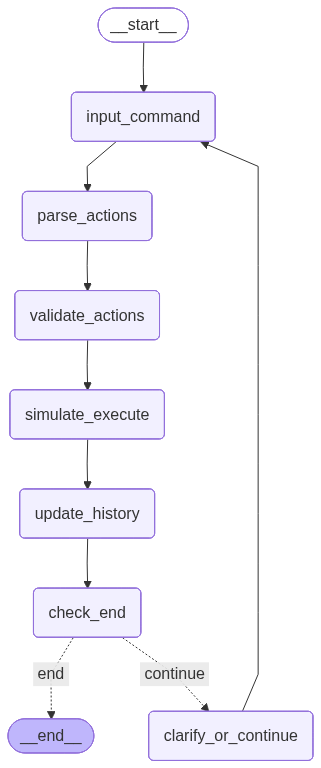

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))